In [1]:
# load data
import deeplake
import numpy as np 
import tensorflow.keras as KERAS 
import tensorflow as tf
from src import *
import os
import matplotlib.pyplot as plt 
config =tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

c:\Users\Lee\anaconda3\envs\tensorflow\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.1.2) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


# Data Proprocess

In [2]:
train = deeplake.load("hub://activeloop/tiny-imagenet-train")
test = deeplake.load("hub://activeloop/tiny-imagenet-test")
val = deeplake.load("hub://activeloop/tiny-imagenet-validation")

hub://activeloop/tiny-imagenet-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/tiny-imagenet-train
hub://activeloop/tiny-imagenet-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/tiny-imagenet-test
hub://activeloop/tiny-imagenet-validation loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/tiny-imagenet-validation


In [3]:
# extract data
train_data_ori = train.images[:, :, :, 0:1].numpy()
train_label = train.labels[:].numpy()

val_data_ori = val.images[:, :, :, 0:1].numpy()
val_label = val.labels[:].numpy()

In [4]:
# turn one channel to three channel
# and resize to 75, 75
train_data_norm = into_three_ch(train_data_ori, (75, 75)) / 255 

val_data_norm = into_three_ch(val_data_ori, (75, 75)) / 255

print(train_data_norm.shape)
print(val_data_norm.shape)

(100000, 75, 75, 3)
(10000, 75, 75, 3)


In [5]:
# encode the label 
label = {l[0] for l in train_label}
num_of_class = len(label)

train_label_idx, mapping = label_shrink(train_label)
train_label_encode = KERAS.utils.to_categorical(train_label_idx, num_classes=num_of_class)

val_label_idx, mapping = label_shrink(val_label, mapping)
val_label_encode = KERAS.utils.to_categorical(val_label_idx, num_classes=num_of_class)

print(train_data_norm.shape)
print(train_label_encode.shape)
print(num_of_class)
print(val_data_norm.shape)
print(val_label_encode.shape)

(100000, 75, 75, 3)
(100000, 200)
200
(10000, 75, 75, 3)
(10000, 200)


# CNN PART

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

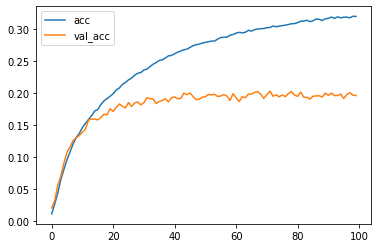

In [6]:
# VGG-19
input_shape = (75, 75, 3)

base = KERAS.applications.VGG19(
    weights='imagenet',
    include_top=False, 
    input_shape=input_shape
)

base.trainable = False 


model = KERAS.models.Sequential(
    [
        base, 
        KERAS.layers.Flatten(), 
        KERAS.layers.Dense(1024, activation='relu'),
        KERAS.layers.Dense(1024, activation='relu'),
        KERAS.layers.Dropout(0.5),
        
        KERAS.layers.Dense(512, activation='relu'),
        KERAS.layers.Dense(512, activation='relu'),
        KERAS.layers.Dropout(0.5),

        KERAS.layers.Dense(128, activation='relu'),
        KERAS.layers.Dense(128, activation='relu'),
        KERAS.layers.Dropout(0.25),

        KERAS.layers.Dense(64, activation='relu'),
        KERAS.layers.Dense(64, activation='relu'),

        KERAS.layers.Dense(num_of_class, activation='softmax')
    ]
)


model.compile(
    loss=KERAS.losses.CategoricalCrossentropy(), 
    optimizer=KERAS.optimizers.RMSprop(), 
    metrics=[KERAS.metrics.CategoricalAccuracy()]
)

model.summary()

history = model.fit(
    train_data_norm, train_label_encode,
    batch_size=256,
    epochs=100,
    validation_data=(val_data_norm, val_label_encode),
    validation_batch_size=100,
    # verbose=0,

    use_multiprocessing=True
)

plot_history(history)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 3, 3, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_12 (Dense)             (None, 512)              

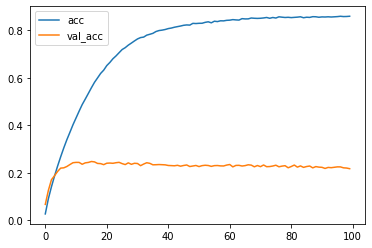

In [7]:
# ResNet50V2

input_shape = (75, 75, 3)

base = KERAS.applications.ResNet50V2(
    weights='imagenet',
    include_top=False, 
    input_shape=input_shape
)

base.trainable = False 


model = KERAS.models.Sequential(
    [
        base, 
        KERAS.layers.Flatten(), 
        KERAS.layers.Dense(1024, activation='relu'),
        KERAS.layers.Dense(1024, activation='relu'),
        KERAS.layers.Dropout(0.5),
        
        KERAS.layers.Dense(512, activation='relu'),
        KERAS.layers.Dense(512, activation='relu'),
        KERAS.layers.Dropout(0.5),

        KERAS.layers.Dense(128, activation='relu'),
        KERAS.layers.Dense(128, activation='relu'),
        KERAS.layers.Dropout(0.25),

        KERAS.layers.Dense(64, activation='relu'),
        KERAS.layers.Dense(64, activation='relu'),

        KERAS.layers.Dense(num_of_class, activation='softmax')
    ]
)



model.compile(
    loss=KERAS.losses.CategoricalCrossentropy(), 
    optimizer=KERAS.optimizers.RMSprop(), 
    metrics=[KERAS.metrics.CategoricalAccuracy()]
)

model.summary()

history = model.fit(
    train_data_norm, train_label_encode,
    batch_size=256,
    epochs=100,
    validation_data=(val_data_norm, val_label_encode),
    validation_batch_size=100,
    # verbose=0,

    use_multiprocessing=True
)

plot_history(history)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_21 (Dense)             (None, 512)              

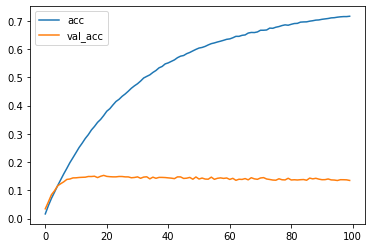

In [8]:
# Inceptionv3
input_shape = (75, 75, 3)

base = KERAS.applications.InceptionV3(
    weights='imagenet',
    include_top=False, 
    input_shape=input_shape
)

base.trainable = False 


model = KERAS.models.Sequential(
    [
        base, 
        KERAS.layers.Flatten(), 
        KERAS.layers.Dense(1024, activation='relu'),
        KERAS.layers.Dense(1024, activation='relu'),
        KERAS.layers.Dropout(0.5),
        
        KERAS.layers.Dense(512, activation='relu'),
        KERAS.layers.Dense(512, activation='relu'),
        KERAS.layers.Dropout(0.5),

        KERAS.layers.Dense(128, activation='relu'),
        KERAS.layers.Dense(128, activation='relu'),
        KERAS.layers.Dropout(0.25),

        KERAS.layers.Dense(64, activation='relu'),
        KERAS.layers.Dense(64, activation='relu'),

        KERAS.layers.Dense(num_of_class, activation='softmax')
    ]
)


model.compile(
    loss=KERAS.losses.CategoricalCrossentropy(), 
    optimizer=KERAS.optimizers.RMSprop(), 
    metrics=[KERAS.metrics.CategoricalAccuracy()]
)

model.summary()

history = model.fit(
    train_data_norm, train_label_encode,
    batch_size=256,
    epochs=100,
    validation_data=(val_data_norm, val_label_encode),
    validation_batch_size=100,
    # verbose=0,

    use_multiprocessing=True
)

plot_history(history)